In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import os
import keras.backend as K
import random

# Flags
PLOT_TRAIN = True
PLOT_TEST = True
PLOT_TEST_LOSS = False
TRAIN_MODEL=True
SAVE_MODEL = True

WIRE_ANTENNA = True
MIFA_ANTENNA = False

In [2]:
def load_data(path: str):
    """
    This function loads data from a pickle file located at the provided path.

    Parameters:
        path (str): The path to the pickle file.

    Returns:
        par_comb (np.ndarray): The parameter combinations.
        S11_par (np.ndarray): The best parametric data.
        frequency (np.ndarray): The frequency data.
        degrees (np.ndarray): The degrees data.
        combined_gain (np.ndarray): The combined gain list.
        std_dev (np.ndarray): The standard deviation of Phi.
        efficiency (np.ndarray): The efficiency data.
    """

    with open(path,'rb') as file:
        data_dict = pickle.load(file)
    print(f"Dictionary keys: {data_dict.keys()}")

    par_comb = np.asarray(data_dict['Parameter combination'])
    S11_vals = np.asarray(data_dict['S1,1'])
    frequency = np.asarray(data_dict['Frequency'])
    S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
    degrees = np.asarray(data_dict['degrees'])
    combined_gain = np.asarray(data_dict['combined gain list'])
    std_dev = np.asarray(data_dict['Standard deviation Phi'])
    efficiency = np.asarray(data_dict['efficiency'])
    #efficiency = np.asarray(list(data_dict['efficiency'].values()))
    return par_comb, S11_vals, S11_parametrized, frequency, degrees, combined_gain, std_dev, efficiency

def normalize_data(data_input, mean, std_dev, inverse: bool):
    if inverse:
        data = data_input*std_dev + mean
    else:   
        mean = mean
        std = std_dev
        data = (data_input-mean)/std
    return data

if WIRE_ANTENNA:
    def load_data(path: str):
        """
        This function loads data from a pickle file located at the provided path.

        Parameters:
            path (str): The path to the pickle file.

        Returns:
            par_comb (np.ndarray): The parameter combinations.
            S11_par (np.ndarray): The best parametric data.
            frequency (np.ndarray): The frequency data.
            degrees (np.ndarray): The degrees data.
            combined_gain (np.ndarray): The combined gain list.
            std_dev (np.ndarray): The standard deviation of Phi.
            efficiency (np.ndarray): The efficiency data.
        """

        with open(path,'rb') as file:
            data_dict = pickle.load(file)
        print(f"Dictionary keys: {data_dict.keys()}")

        par_comb = np.asarray(data_dict['Parameter combination'])
        S11_vals = np.asarray(data_dict['S1,1'])
        frequency = np.asarray(data_dict['Frequency'])
        S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
        degrees = np.asarray(data_dict['degrees'])
        combined_gain = np.asarray(data_dict['combined gain list'])
        std_dev = np.asarray(data_dict['Standard deviation Phi'])
        efficiency = np.asarray(data_dict['efficiency'])
        #efficiency = np.asarray(list(data_dict['efficiency'].values()))
        return par_comb, S11_vals, S11_parametrized, frequency, degrees, combined_gain, std_dev, efficiency

elif MIFA_ANTENNA:
    def load_data(path: str):
        """
        This function loads data from a pickle file located at the provided path.

        Parameters:
            path (str): The path to the pickle file.

        Returns:
            par_comb (np.ndarray): The parameter combinations.
            S11_par (np.ndarray): The best parametric data.
            frequency (np.ndarray): The frequency data.
            degrees (np.ndarray): The degrees data.
            combined_gain (np.ndarray): The combined gain list.
            std_dev (np.ndarray): The standard deviation of Phi.
            efficiency (np.ndarray): The efficiency data.
        """

        with open(path,'rb') as file:
            data_dict = pickle.load(file)
        print(f"Dictionary keys: {data_dict.keys()}")

        par_comb = np.asarray(data_dict['Parameter combination'])
        S11_vals = np.asarray(data_dict['S1,1'])
        frequency = np.asarray(data_dict['Frequency'])
        # S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
        degrees = np.asarray(data_dict['degrees'])
        combined_gain = np.asarray(data_dict['combined gain list'])
        std_dev = np.asarray(data_dict['Standard deviation Phi'])
        efficiency = np.asarray(data_dict['efficiency'])
        #efficiency = np.asarray(list(data_dict['efficiency'].values()))
        return par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency
    
def normalize_data(data_input, mean, std_dev, inverse: bool):
    if inverse:
        data = data_input*std_dev + mean
    else:   
        mean = mean
        std = std_dev
        data = (data_input-mean)/std
    return data

if WIRE_ANTENNA:
    def weighted_loss(y_true, y_pred):
        e = y_pred - y_true
        # Apply different weights based on the input parameters
        e1 = e[:, :2]*5 # Increase the weight for the first two parameters
        e2 = e[:, 2:]
        return K.mean(K.square(K.concatenate([e1, e2], axis=-1)), axis=-1)


if MIFA_ANTENNA:
    def weighted_loss(y_true, y_pred):
        e = y_pred - y_true
        # Apply different weights based on the input parameters
        e1 = e[:, 0]*5
        e2 = e[:, 2]*5# Increase the weight for the first two parameters
        e3 = e[:, 1]
        e4 = e[:, 3]
        
        return K.mean(K.square(K.concatenate([e1, e2, e3, e4], axis=-1)), axis=-1)

In [3]:
path = 'C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/'

if WIRE_ANTENNA:
    par_comb, S11_vals, S11_parameterized, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/data/Wire_results/simple_wire2_final_with_parametric.pkl")
elif MIFA_ANTENNA:
    par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/data/MIFA_results/MIFA_results.pkl")
    
# # Normalize data
# par_comb_norm = normalize_data(par_comb,np.mean(par_comb),np.std(par_comb), False)
# S11_vals_norm = normalize_data(S11_vals,np.mean(S11_vals),np.std(S11_vals), False)


# frequency_norm = normalize_data(frequency, np.mean(frequency),np.std(frequency), False)
# degrees_norm = normalize_data(degrees, np.mean(degrees),np.std(degrees), False)
# combined_gain_norm = normalize_data(combined_gain, np.mean(combined_gain),np.std(combined_gain), False)
# std_dev_norm = normalize_data(std_dev, np.mean(std_dev),np.std(std_dev), False)
# efficiency_norm = normalize_data(efficiency, np.mean(efficiency),np.std(efficiency), False)


output_vector = par_comb

# input_vector = np.asarray([np.concatenate((S11_vals_norm[i], [std_dev_norm[i]], [efficiency_norm[i]]))for i in range(S11_vals.shape[0])])
input_vector = S11_vals

print(f'Output vector shape: {output_vector.shape}')
print(f'Input vector shape: {input_vector.shape}')

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, shuffle=True, random_state=42)

std_dev = y_test[:,-2]
efficiency = y_test[:,-1]

#Normalize the input and output vectors
x_train_norm = normalize_data(x_train, np.mean(x_train), np.std(x_train), False)
x_test_norm = normalize_data(x_test, np.mean(x_test), np.std(x_test), False)
y_train_norm = normalize_data(y_train, np.mean(y_train), np.std(y_train), False)
y_test_norm = normalize_data(y_test, np.mean(y_test), np.std(y_test), False)



Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])
Output vector shape: (2508, 3)
Input vector shape: (2508, 1001)


In [4]:
if TRAIN_MODEL:
    model = keras.Sequential([
        layers.InputLayer(input_shape=(input_vector.shape[1])),
        layers.Dense(256, activation='relu', name = 'layer1', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', name = 'layer2', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', name = 'layer3', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', name = 'layer4', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', name = 'layer5', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', name = 'layer6', kernel_regularizer=keras.regularizers.l2(0.001)),
        # layers.Dense(256, activation='relu', name = 'layer7', kernel_regularizer=keras.regularizers.l2(0.001)),

    #    layers.Dense(256, activation='relu', name = 'layer5'),
        layers.Dense(output_vector.shape[1], activation = 'linear', name = 'Output_layer')
    ])

    model.summary()


    # Compile the model with the solver adam and the loss function MSE
    if WIRE_ANTENNA:
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=weighted_loss,
            metrics=[keras.metrics.MeanSquaredError()]
        )
    elif MIFA_ANTENNA:
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=weighted_loss,
            metrics=[keras.metrics.MeanSquaredError()]
            
        )

    #Create lists to store the results
    loss_train = []
    mean_error_train = []
    mean_error_pred = np.zeros(50)
    # Train the model
    model.fit(
        x=x_train_norm,
        y=y_train_norm,
        batch_size=100,
        epochs=500,
        shuffle=False,
        callbacks=[keras.callbacks.History()]
    )

    # Define the loss and accuracy for the training and test data
    loss_train.extend(model.history.history['loss'])
    mean_error_train.extend(model.history.history['mean_squared_error'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 256)               256512    
                                                                 
 layer2 (Dense)              (None, 256)               65792     
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 256)               65792     
                                                                 
 layer5 (Dense)              (None, 256)               65792     
                                                                 
 layer6 (Dense)              (None, 256)               65792     
                                                                 
 Output_layer (Dense)        (None, 3)                 7

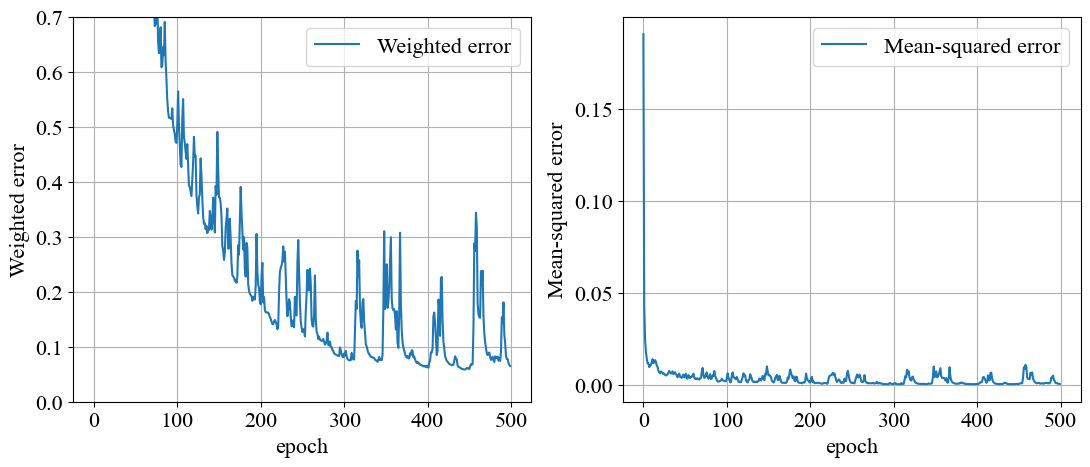

24/24 [==============================] - 0s 2ms/step - loss: 0.0697 - mean_squared_error: 8.3831e-04
y_pred_norm shape: (753, 3)


In [5]:
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 16})      

if PLOT_TRAIN:
    if WIRE_ANTENNA:
        plt.figure(figsize=(13,5))
        plt.subplot(121)
        plt.grid(True)
        plt.plot(np.array(loss_train).T)
        plt.ylabel('Weighted error')
        plt.xlabel('epoch')
        plt.legend(['Weighted error'])
        plt.ylim([0, 0.7])
        plt.subplot(122)
        plt.grid(True)
        plt.plot((np.array(mean_error_train).T))
        plt.ylabel('Mean-squared error')
        plt.xlabel('epoch')
        plt.legend(['Mean-squared error'])
        #plt.ylim([0, 0.7])
        
        train_loss_path = os.path.join(path, 'data', 'Wire_results', f'Wire_train_loss_inverse.pdf').replace("\\", "/")
        plt.savefig(train_loss_path, format="pdf", bbox_inches="tight") 
        plt.show()
         
        # plt.show()
        # plt.savefig(f'data/DNN_results_reversal/train_loss/loss_{(j+1)*100}.png')
        plt.close()
    elif MIFA_ANTENNA:
        plt.figure(figsize=(13,5))
        plt.subplot(121)
        plt.grid(True)
        plt.plot(np.array(loss_train).T)
        plt.ylabel('Weighted error')
        plt.xlabel('epoch')
        plt.legend(['Weighted error'])
        plt.ylim([0, 0.7])
        plt.subplot(122)
        plt.grid(True)
        plt.plot(np.array(mean_error_train).T)
        plt.ylabel('Mean-squared error')
        plt.xlabel('epoch')
        plt.legend(['Mean-squared error'])
        #plt.ylim([0, 0.7])
        
        train_loss_path = os.path.join(path, 'data', 'MIFA_results', f'MIFA_train_loss_inverse.pdf').replace("\\", "/")
        plt.savefig(train_loss_path, format="pdf", bbox_inches="tight")  
        
        plt.show()
        # plt.savefig(f'data/DNN_results_reversal/train_loss/loss_{(j+1)*100}.png')
        plt.close()
# Run the model on the test data and get the loss and mean-squared error
y_pred_norm = model.predict(x_test_norm)
_ , mean_error_pred = model.evaluate(x_test_norm, y_test_norm)

#Reverse normalization
#Reverse the normalization of the data individually
print(f"y_pred_norm shape: {y_pred_norm.shape}")
y_pred = normalize_data(y_pred_norm, np.mean(y_train), np.std(y_train), True)


[340, 424, 215, 718]


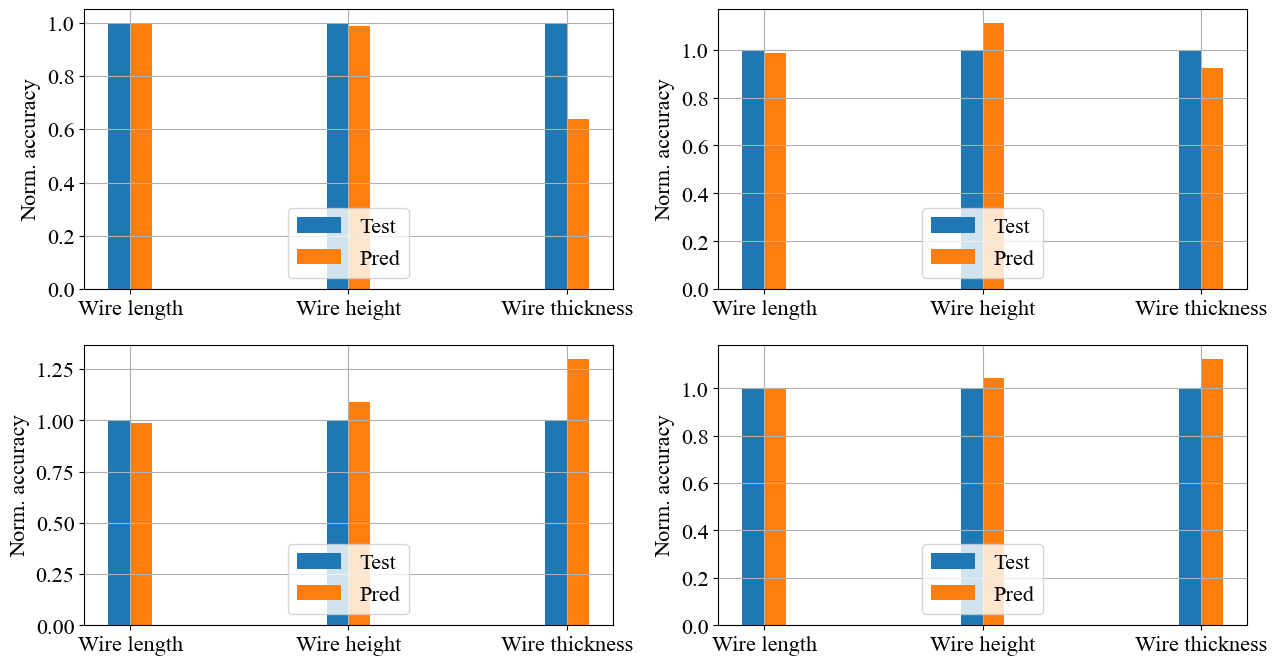

In [18]:
# Plot the testing results
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 16})
if PLOT_TEST:
    # Make a grouped bar plot with the predicted parameters and the test parameters
    random_indices = random.sample(range(0, y_pred.shape[0]), 4)
    print(random_indices)
    plt.figure(figsize=(15, 8))
    width = 0.1  # the width of the bars
    if WIRE_ANTENNA:
        labels = ["Wire length", "Wire height", "Wire thickness"]
        for idx, i in enumerate(random_indices):
            plt.subplot(2, 2, idx+1)
            plt.grid(True)
            bars2 = plt.bar(np.arange(1,4) - width/2, y_test[i]/y_test[i], width)
            bars1 = plt.bar(np.arange(1,4) + width/2, y_pred[i]/y_test[i], width)
            plt.ylabel('Norm. accuracy')
            plt.xticks(np.arange(1,4), labels)
            plt.legend([bars2, bars1], ['Test', 'Pred'], loc='lower center')
            test_pred_path = os.path.join(path, 'data', 'Wire_Results', f'Wire_bar_plot_inverse.pdf').replace("\\", "/")
            plt.savefig(test_pred_path, format="pdf", bbox_inches="tight") 
             
    elif MIFA_ANTENNA:
        labels = ['Tw1','groundingPin\nTopLength','Line1_height','substrateH']
        for idx, i in enumerate(random_indices):
            plt.subplot(2, 2, idx+1)
            plt.grid(True)
            bars2 = plt.bar(np.arange(1,5) - width/2, y_test[i]/y_test[i], width)
            bars1 = plt.bar(np.arange(1,5) + width/2, y_pred[i]/y_test[i], width)
            plt.ylabel('Norm. accuracy')
            plt.xticks(np.arange(1,5), labels)
            plt.legend([bars2, bars1], ['Test', 'Pred'], loc='lower center')
            test_pred_path = os.path.join(path, 'data', 'MIFA_results', f'MIFA_bar_plot_inverse.pdf').replace("\\", "/")
            plt.savefig(test_pred_path, format="pdf", bbox_inches="tight") 
            
    # plt.show()

In [19]:
if SAVE_MODEL:
    if WIRE_ANTENNA:
        model.save('data/Wire_results/wire_inverse_model_1.keras', overwrite=True)
    elif MIFA_ANTENNA:
        model.save('data/MIFA_results/MIFA_inverse_model_1.keras', overwrite=True) 